# Working with local files

At heart, `contextily` is a package to work with data from the web. Its main functionality allows you to access tilesets exposed through the popular XYZ format and include them in your workflow through `matplotlib`. However, a little hidden gem in the pacakge is also how it is useful to work with local files. For all this functionality, `contextily` relies on `rasterio` so, in the name of showing how a streamlined workflow could look like, we will switch back and forth between the two in this notebook. For good measure, we will also use `geopandas` as it'll show how they are all a family that works great together!

In [1]:
%matplotlib inline

import contextily as ctx
import geopandas
import rasterio
from rasterio.plot import show as rioshow
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

## Saving tiles locally

The first usecase is when you want to store locally a basemap you have accessed with `contextily`. For example, let's say  you are visualising a point dataset. In this case, let's pull the [CLIWOC `routes`](https://figshare.com/articles/CLIWOC_Slim_and_Routes/11941224) dataset, which records ship routes from the XVIIth to XIXth Centuries:

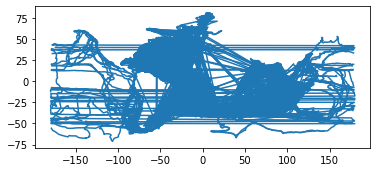

In [2]:
cliwoc = geopandas.read_file("https://ndownloader.figshare.com/files/21940242")
cliwoc.plot()

A quick plot reveals some structure, but it is a bit hard to see much. Let's style the routes a bit and add a basemap:

/opt/conda/lib/python3.7/site-packages/contextily/tile.py:580: RuntimeWarning: divide by zero encountered in log2
  zoom_lon = np.ceil(np.log2(360 * 2.0 / lon_length))


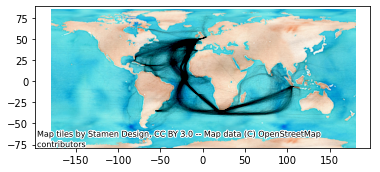

In [3]:
ax = cliwoc.plot(linewidth=0.01, alpha=0.5, color="k")
ctx.add_basemap(ax, 
                crs=cliwoc.crs.to_string(),
                source=ctx.providers.Stamen.Watercolor
               )

Now this is better! But imagine that you wanted to take this map to a Desktop GIS (like [QGIS](https://qgis.org/en/site/)) and maybe do some more work; or that you simply wanted to retain a copy of the basemap in case you need to work offline. In those cases, `contextily` lets you download a basemap off the internet directly into a common GeoTIF file.

### Raster from bounds

The workhorse here is `bounds2raster`, which expects a bounding box and downloads a basemap for that area into a local `.tif` file. Let's see for the example above. First, we need to extract the bounds of our dataset, which will set the extent of the download:

In [4]:
west, south, east, north = bbox = cliwoc.total_bounds
bbox

array([-179.98,  -71.17,  179.98,   80.8 ])

Then we can download the tile:

In [5]:
img, ext = ctx.bounds2raster(west, 
                             south, 
                             east, 
                             north, 
                             "world_watercolor.tif", 
                             source=ctx.providers.Stamen.Watercolor,
                             ll=True
                            )

Note that, since our bounding box was expressed in lon/lat, we pass `ll=True` so the function knows about it. 

You should now see a file written locally named `world_watercolor.tif`. This is saved in a standard format that any GIS should be able to read. In Python, the quickest way to visualise a `GeoTIF` file is with `rasterio`:

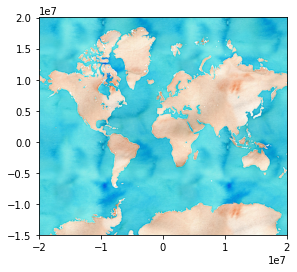

In [6]:
with rasterio.open("world_watercolor.tif") as r:
    rioshow(r)

Note how the data is the same as in the figure above, but it's expressed in a different projection. This is because a basemap is always stored in its original CRS, Web Mercator. See below how you can modify that on-the-fly with `contextily`.

### Raster from name

The other option `contextily` includes to save rasters is through its Place API, which allows you to query locations through their names (thanks to [`geopy`](https://geopy.readthedocs.io/en/stable/)). For example, we can retrieve a basemap of Sao Paulo:

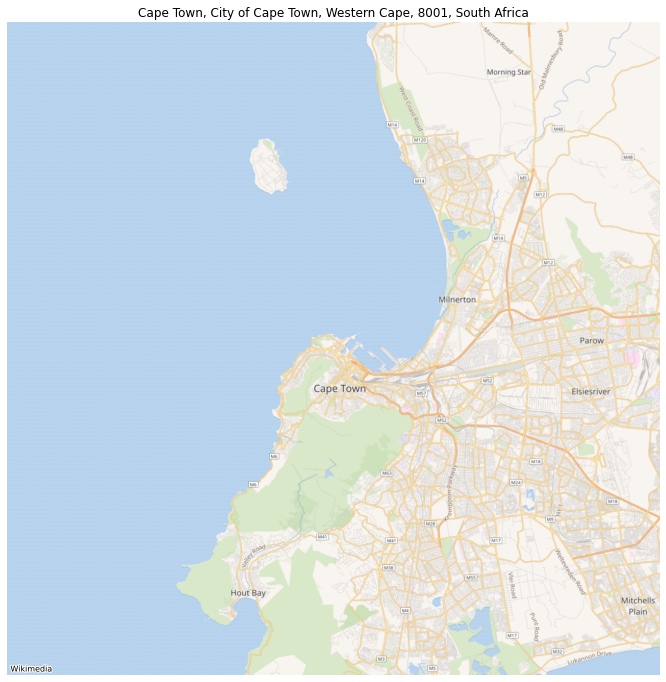

In [7]:
sao_paulo = ctx.Place("Cape Town", source=ctx.providers.Wikimedia)
sao_paulo.plot()

Now, if we want to store the basemap in a file as we download it, you can pass a path to the `path` argument:

In [8]:
sao_paulo = ctx.Place("Cape Town", source=ctx.providers.Wikimedia, path="cape_town.tif")

And this should create a new file on your local directory.

## Reading local rasters

### Reading with `rasterio`

`rasterio` allows us to move quickly from file to plot if we want to inspect what's saved:

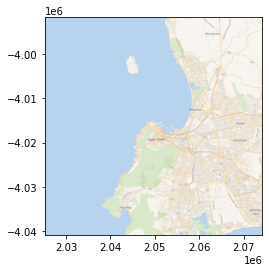

In [9]:
with rasterio.open("cape_town.tif") as r:
    rioshow(r)

### Reading with `add_basemap`

If we are combining a locally stored raster with other data (e.g. vector), `contextily.add_basemap` provides a few goodies that make it worth considering.

---

**[Data preparation detour]**

To demonstrate this functionality, we will first clip out the sections of the CLIWOC routes within the bounding box of Cape Town:

In [10]:
with rasterio.open("cape_town.tif") as r:
    west, south, east, north = tuple(r.bounds)
    cape_town_crs = r.crs
bb_poly = Polygon([[west, south],
                   [east, south],
                   [east, north],
                   [west, north],
                   [west, south]
                  ])
bb_poly = geopandas.GeoDataFrame({"geometry": [bb_poly]}, 
                                 crs=cape_town_crs
                                )

With a `GeoDataFrame` for the area (`bb_poly`), we can clip from the routes:

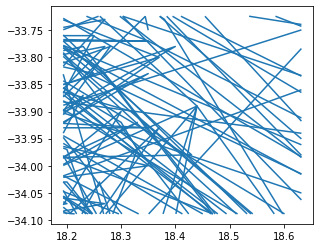

In [11]:
cliwoc_cape_town = geopandas.overlay(cliwoc, 
                                     bb_poly.to_crs(cliwoc.crs), 
                                     how="intersection"
                                    )
cliwoc_cape_town.plot()

Additionally, for the sake of the illustration, we will also clip routes within 10Km of the center of Cape Town (Pseudo-Mercator is definitely not the best projection for calculating distances, but to keep this illustration concise, it'll do):

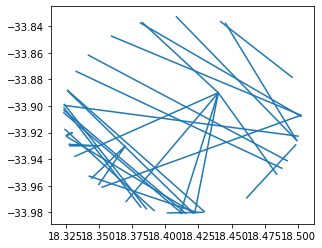

In [12]:
cape_town_buffer = geopandas.GeoDataFrame({"geometry": bb_poly.centroid.buffer(10000)},
                                          crs=bb_poly.crs
                                         )
cliwoc_cape_town_buffer = geopandas.overlay(cliwoc, 
                                            cape_town_buffer.to_crs(cliwoc.crs), 
                                            how="intersection"
                                           )
cliwoc_cape_town_buffer.plot()

---

Now, we can use `add_basemap` to add a local raster file as the background to our map. Simply replace a web `source` for the path to the local file, and you'll be set!

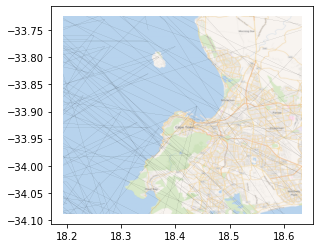

In [13]:
ax = cliwoc_cape_town.plot(linewidth=0.05, color="k")
ctx.add_basemap(ax, 
                crs=cliwoc_cape_town.crs.to_string(), 
                source="cape_town.tif"
               )

Note how the `crs` functionality works just as expected in this context as well. `contextily` checks the CRS of the local file and, if it is different from that specified in the `crs` parameter, it warps the image so they align automatically.

Same as with web tiles, we can "dim" the basemap by boosting up transparency:

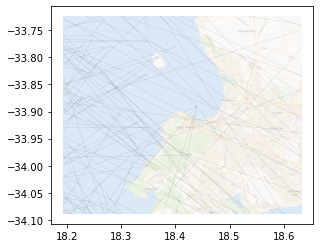

In [14]:
ax = cliwoc_cape_town.plot(linewidth=0.05, color="k")
ctx.add_basemap(ax, 
                crs=cliwoc_cape_town.crs.to_string(), 
                source="cape_town.tif",
                alpha=0.5
               )

The `add_basemap` method has the `reset_extent` parameter, which is set to `True` by default. When loading local rasters, this option uses the axis bounds and loads *only* the portion of the raster within the bounds. This results in two key benefits: first, the original axis is not modified in its extent, so you are still displaying exactly what you wanted, regardless of the extent of the raster you use on the basemap; and second, the method is very efficient even if your raster is large and has wider coverage (only the portion of the raster needed to cover the axis is accessed and loaded).

This can be better demonstrated using the buffer clip:

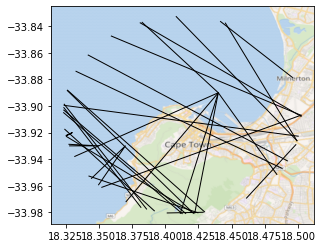

In [15]:
ax = cliwoc_cape_town_buffer.plot(linewidth=1, color="k")
ctx.add_basemap(ax, 
                crs=cliwoc_cape_town.crs.to_string(), 
                source="cape_town.tif"
               )

Now, `reset_extent` can be turned off when you want to modify the original axis bounds to include the full raster you use as basemap. The effect is clearly seen in the following figure:

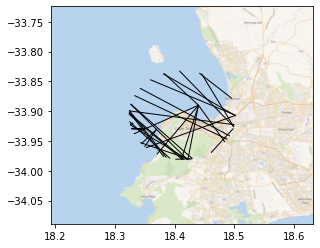

In [16]:
ax = cliwoc_cape_town_buffer.plot(linewidth=1, color="k")
ctx.add_basemap(ax, 
                crs=cliwoc_cape_town.crs.to_string(), 
                source="cape_town.tif",
                reset_extent=False
               )

These two options give you flexibility to use the local rasters features in different contexts. 